In [1]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import os

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Warnings configuration
# ==============================================================================
import warnings
#warnings.filterwarnings('ignore')

In [3]:
rsmes = []
maes = []
r2s = []

In [4]:
MONTHLY_DATA_PATH = os.path.abspath(r"..\data").replace('\\','/') + '/processed/monthly_rainfall.xlsx'
WEEKLY_DATA_PATH = os.path.abspath(r"..\data").replace('\\','/') + '/processed/weekly_rainfall_avg.xlsx'
DAILY_DATA_PATH = os.path.abspath(r"..\data").replace('\\','/') + '/processed/daily_rainfall.xlsx'

monthly_df = pd.read_excel(MONTHLY_DATA_PATH, 
                           index_col=[0],
                           parse_dates=[0])

monthly_df.index.freq = 'MS' 

weekly_df = pd.read_excel(WEEKLY_DATA_PATH,
                          index_col=[0],
                          parse_dates=[0])

daily_df = pd.read_excel(DAILY_DATA_PATH,
                         index_col=[0], 
                         parse_dates=[0])

In [5]:
monthly_df.head()

,monhtly_avg
months,
2014-01-01,60.0
2014-02-01,101.5
2014-03-01,133.5
2014-04-01,117.0
2014-05-01,16.5


In [6]:
monthly_df.shape

(96, 1)

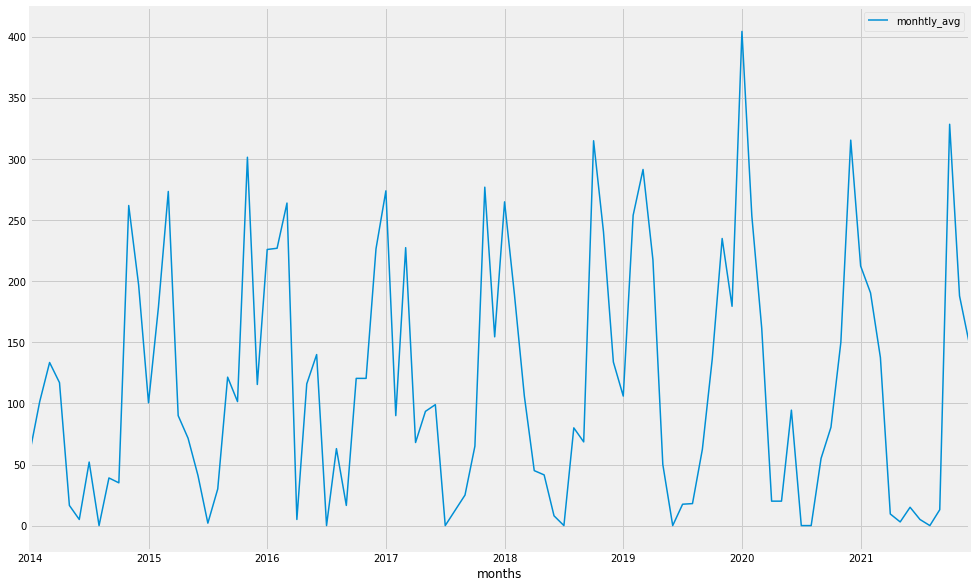

In [7]:
monthly_df.plot(figsize=(15,10))
plt.show()

In [8]:
data = monthly_df.copy()

Train dates : 2014-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=72)
Test dates  : 2020-01-01 00:00:00 --- 2021-12-01 00:00:00  (n=24)


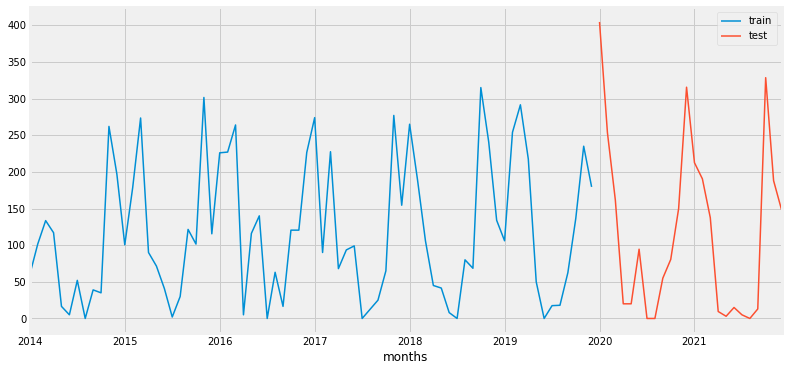

In [9]:
steps = 24
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax = plt.subplots(figsize=(12,6))
data_train['monhtly_avg'].plot(ax=ax, label='train')
data_test['monhtly_avg'].plot(ax=ax, label='test')
ax.legend();

In [10]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6
             )

forecaster.fit(data_train['monhtly_avg'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Window size: 6 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2014-01-01 00:00:00'), Timestamp('2019-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-09-26 16:14:01 
Last fit date: 2022-09-26 16:14:01 
Skforecast version: 0.4.3 

In [11]:
# Predictions
# ==============================================================================
steps = 24
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2020-01-01    179.388
2020-02-01    159.933
2020-03-01    139.625
2020-04-01     50.645
2020-05-01     16.615
Freq: MS, Name: pred, dtype: float64

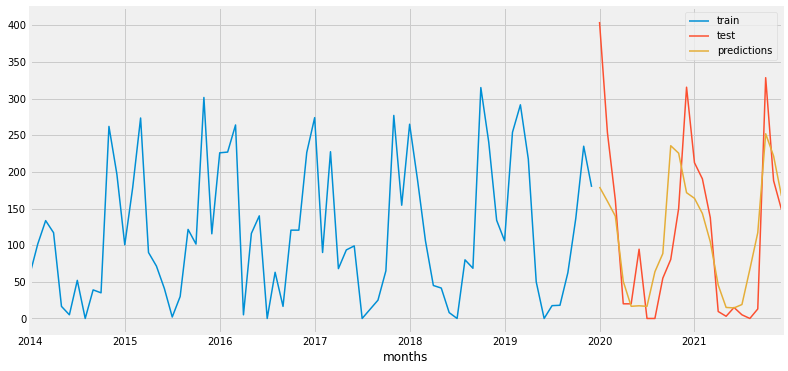

In [12]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12,6))
data_train['monhtly_avg'].plot(ax=ax, label='train')
data_test['monhtly_avg'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

Root Mean Squared Error (RSME): 79.77
Correlation Coefficient: 0.54


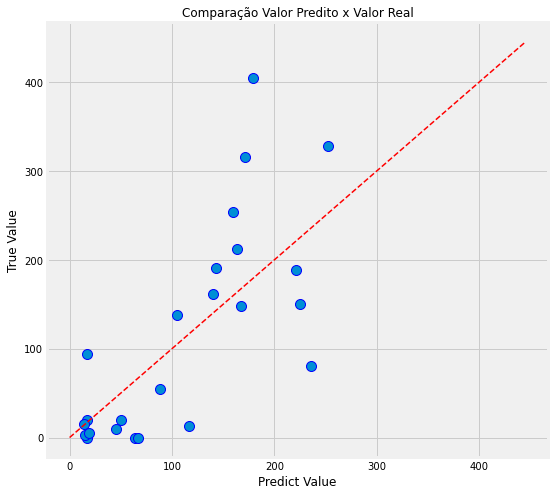

In [13]:
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )

rsmes.append(error_mse**0.5)

print(f"Root Mean Squared Error (RSME): {error_mse**0.5:.2f}")

print(f"Correlation Coefficient: {r2_score(data_test, predictions):.2f}")
r2s.append(r2_score(data_test, predictions))

# Vamos criar um gráfico para comparar os Valores Reais com os Preditos
fig = plt.figure(figsize=(8,8))
l = plt.plot(predictions.values, data_test.values, 'bo')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')
plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.xlabel("Predict Value", fontsize=12)

# mostra os valores preditos e originais
xl = np.arange(min(data_test.values), 1.2*max(data_test.values),(max(data_test.values)-min(data_test.values))/10)
yl = xl
plt.plot(xl, yl, 'r--')
plt.show()

In [14]:
# Hyperparameter Grid search
# ==============================================================================
steps = 24
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [5,6,7]


# Regressor's hyperparameters
param_grid = {'n_estimators': [150, 200],
              'max_depth': [8, 10, 12],
             }

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['monhtly_avg'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 18


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:18<00:00,  6.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 8, 'n_estimators': 150}
  Backtesting metric: 7170.4078002252445



In [15]:
# Grid Search results
# ==============================================================================
results_grid

,lags,params,metric,max_depth,n_estimators
6,"[1, 2, 3, 4, 5, 6]","{'max_depth': 8, 'n_estimators': 150}",7170.407800,8,150
8,"[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'n_estimators': 150}",7229.137827,10,150
10,"[1, 2, 3, 4, 5, 6]","{'max_depth': 12, 'n_estimators': 150}",7233.994678,12,150
13,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 8, 'n_estimators': 200}",7356.446104,8,200
14,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 150}",7399.003735,10,150
16,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 12, 'n_estimators': 150}",7399.211529,12,150
15,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 10, 'n_estimators': 200}",7414.762400,10,200
17,"[1, 2, 3, 4, 5, 6, 7]","{'max_depth': 12, 'n_estimators': 200}",7418.931330,12,200
9,"[1, 2, 3, 4, 5, 6]","{'max_depth': 10, 'n_estimators': 200}",7460.801295,10,200
11,"[1, 2, 3, 4, 5, 6]","{'max_depth': 12, 'n_estimators': 200}",7475.642144,12,200


In [16]:
steps = 24
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2020-01-01    181.033878
2020-02-01    165.162091
2020-03-01    137.079552
2020-04-01     60.737335
2020-05-01     30.531434
Freq: MS, Name: pred, dtype: float64

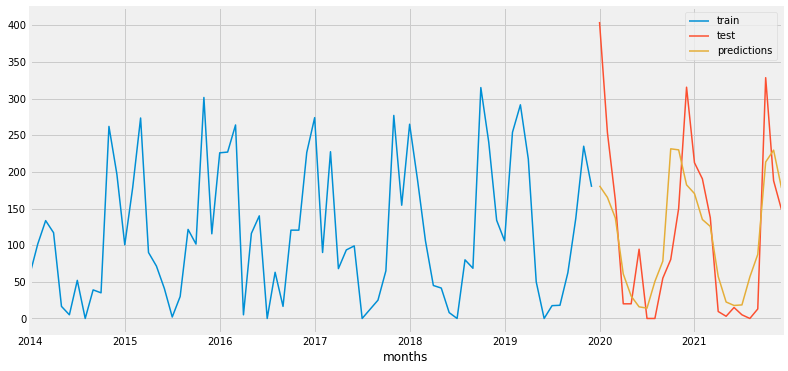

In [17]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(12,6))
data_train['monhtly_avg'].plot(ax=ax, label='train')
data_test['monhtly_avg'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

Root Mean Squared Error (RSME): 78.78
Correlation Coefficient: 0.55


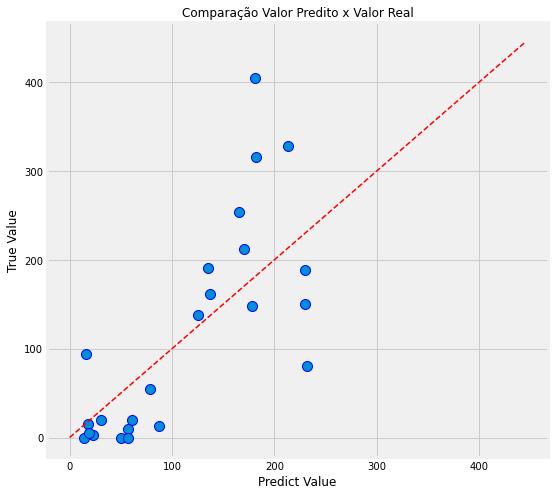

In [18]:
error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )

rsmes.append(error_mse**0.5)

print(f"Root Mean Squared Error (RSME): {error_mse**0.5:.2f}")

print(f"Correlation Coefficient: {r2_score(data_test, predictions):.2f}")
r2s.append(r2_score(data_test, predictions))

# Vamos criar um gráfico para comparar os Valores Reais com os Preditos
fig = plt.figure(figsize=(8,8))
l = plt.plot(predictions.values, data_test.values, 'bo')
plt.setp(l, markersize=10)
plt.setp(l, markerfacecolor='C0')
plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.xlabel("Predict Value", fontsize=12)

# mostra os valores preditos e originais
xl = np.arange(min(data_test.values), 1.2*max(data_test.values),(max(data_test.values)-min(data_test.values))/10)
yl = xl
plt.plot(xl, yl, 'r--')
plt.show()